# Zermelo problem, example 1

We consider the Zermelo-type optimal control problem with loss control regions given by

\begin{equation}
\begin{array}{lcl}
     \text{minimize}&  &-x_1(8),\\[10pt]
     \text{subject to}& &  (x,u) \in \mathrm{AC}([0,8],\R^2) \times \mathrm{L}^\infty([0,8],\R), \\[6pt]
     & & \dot{x}_1(t) = x_2(t) + \cos(u(t)), \quad \text{a.e.\ } t\in [0,8], \\[6pt]
     & & \dot{x}_2(t) = \sin(u(t)), \quad \text{a.e.\ } t\in [0,8], \\[6pt]
     &  & x(0)=0_{\R^2}, \quad x_2(8)=4,  \\[6pt]
     &  & u(t) \in [-\frac{\pi}{2},\frac{\pi}{2}], \quad \text{a.e.\ } t\in [0,8],
     \\[6pt]
     &  &u \text{ is constant when } x \text{ is in the loss control region }
     \{x \in \mathbb{R}^2 \mid 0.5 < x_2 < 3.5 \}.
\end{array}
\end{equation}

## Reformulation for the direct method

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8) + \varepsilon\int_0^8 v^2(t)dt + \int_0^1 f_{NC}(x(t))u^2(t)dt, \\[0.5em]
        \dot{x}_1(t) = f_{C}(x(t))(x_2(t) + \cos(u(t))) + f_{NC}(x_2(t) + \cos(\lambda(t))), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = f_{C}(x(t))\sin(u(t)) + f_{NC}(x(t))\sin(\lambda(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        \dot{\lambda}(t) = f_{C}(x(t))v^2(t),  \; \text{for a.e. } t\in [0,8], \\[0.5em]

        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \in \mathbb{R}^2 \mid 0.5 < x_2 < 3.5 \} \text{ is a loss control region.}
    \end{array}
    \right.
$$

REMARQUE OLIVIER :

Il me semble que la contrainte sur le contrôle est inutile car pour maximiser x1, il faut pousser à droite. De plus on voit sur la solution que la contrainte n'est jamais saturée. Il me semble que l'on pourrait l'enlever. Par contre, d'un point de vue numérique avec JuMP, c'est mieux de toujours mettre des contraintes de boites sur les variables, ça aide à la convergence. Pour montrer que pi/2 n'est pas nécessaire, j'ai remplacé dans JuMP par par 2.

In [1]:
using JuMP 
using Ipopt
using Plots
using Plots.PlotMeasures
using LaTeXStrings

In [2]:
mutable struct Direct
    t; x1; x2 ; λ ; u ; xu ; xv ; p1 ; p2
end

mutable struct DirecttSol
    t; x1; x2 ; λ ; u ; v ; xu ; xv ; p1 ; p2 ; p3 
end

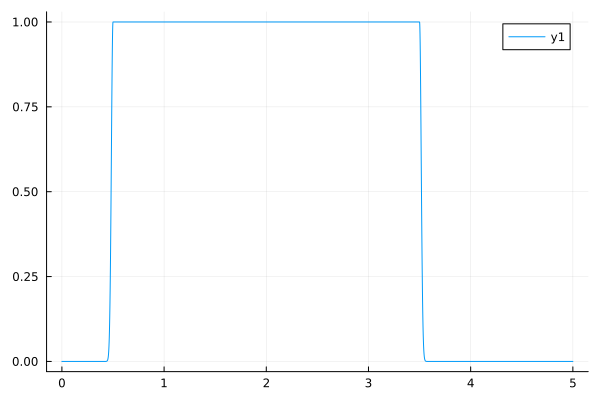

In [3]:
distance_squared(x, a, b) = x < a ? (a - x)^2 : x > b ? (x - b)^2 : 0 ;

# Moreau Yosida regularization
function MY_reg(x, a, b, k)
    return 1 - exp(-k*distance_squared(x, a, b))
end

fC(x) = MY_reg(x, 0.5, 3.5, 2000)
fNC(x) = 1 - fC(x)

plot(fNC, 0, 5)

In [4]:
function ZERMELO(ε=1e-3; x0=[0, 0], nsteps=1000, tol=1e-10, display=true)
    """
        Solve the Zermelo problem with the given parameters.

        Parameters
        ----------

        x0 : array of floats
            Initial condition
        nsteps : int
            Number of steps in the discretization
        ε : float
            Regularization parameter
        tol : float
            Tolerance for the solver
        display : bool
            If true, display the results

        Returns
        -------
        
        sol : DirecttSol
            The (direct) solution of the problem

    """

    # Create JuMP model, using Ipopt as the solver
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => display ? 5 : 1))
    set_optimizer_attribute(sys,"tol", tol)
    set_optimizer_attribute(sys,"constr_viol_tol", tol)
    set_optimizer_attribute(sys,"max_iter", 200)
    
    # Constants
    N  = nsteps     # Grid size
    
    # Variables
    @variables(sys, begin
        x1[1:N+1]
        x2[1:N+1]
        -2  ≤  λ[1:N+1]  ≤ 2 # we add box constraints to help the convergence
        -2  ≤  u[1:N+1]  ≤ 2
        v[1:N+1]
        xv[1:N+1]
        xu[1:N+1]
    end)
    
    # Objective
    @NLobjective(sys, Min, -x1[N+1] + ε*xv[N+1] + xu[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_xu0, xu[1]   == 0
        con_xv0, xv[1]   == 0
        con_x10, x1[1]   == x0[1]
        con_x20, x2[1]   == x0[2]
        con_x2f, x2[N+1] == 4
        end)
    
    # Expressions for the dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j] + fNC(x2[j])*cos(λ[j]) + fC(x2[j])*cos(u[j]))
    @NLexpression(sys, dx2[j = 1:N+1],         fNC(x2[j])*sin(λ[j]) + fC(x2[j])*sin(u[j]))
    @NLexpression(sys,  dλ[j = 1:N+1], fC(x2[j])*v[j])
    @NLexpression(sys, dxv[j = 1:N+1], v[j]^2)
    @NLexpression(sys, dxu[j = 1:N+1], fNC(x2[j])*u[j]^2)
    
    # Dynamics with Crank-Nicolson scheme
    Δt = 8/(N+1)
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N],  λ[j+1] ==  λ[j] + 0.5 * Δt * (dλ[j+1]  + dλ[j])
        con_dxv[j=1:N], xv[j+1] == xv[j] + 0.5 * Δt * (dxv[j+1] + dxv[j])
        con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    λ  = value.(λ)[:]
    u  = value.(u)[:]
    v  = value.(v)[:]
    xu  = value.(xu)[:]
    xv  = value.(xv)[:]
    t  = (0:N) * value.(Δt)
    
    # duals of the boundary constraints
    px10 = -dual(con_x10)
    px20 = -dual(con_x20)
    px30 = 0 # λ(0) is free
    px1f = 1
    px2f = dual(con_x2f) 
    px3f = 0 # λ(4) is free

    # duals of the dynamics
    px1 = -[ dual(con_dx1[i]) for i in 1:N ]
    px2 = -[ dual(con_dx2[i]) for i in 1:N ]
    px3 = -[ dual(con_dx3[i]) for i in 1:N ]

    # adjoint vectors
    p1 = [px10; (px1[1:N-1]+px1[2:N])/2; px1f]
    p2 = [px20; (px2[1:N-1]+px2[2:N])/2; px2f]
    p3 = [px30; (px3[1:N-1]+px3[2:N])/2; px3f]

    return DirecttSol(t, x1, x2, λ, u, v, xu, xv, p1, p2, p3)
        
end;

In [5]:
# Resolution
ε = 1e-3
sol_direct = ZERMELO(ε);

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    30005
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    34000

Total number of variables............................:     7007
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2002
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5005
Total number of in

┌ Warning: Function fNC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fNC, 1, fNC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370
┌ Warning: Function fC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fC, 1, fC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


xu = 0.019619164191148557
xv = 0.010565925235049853


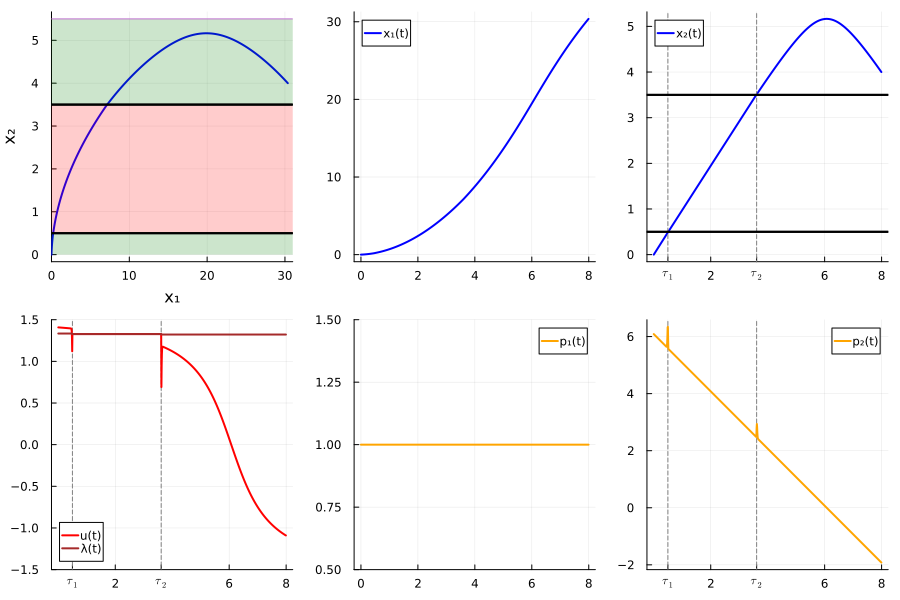

In [6]:
# Plots
t  = sol_direct.t
x1 = sol_direct.x1
x2 = sol_direct.x2
u  = sol_direct.u
v  = sol_direct.v
λ  = sol_direct.λ
xu = sol_direct.xu
xv = sol_direct.xv
p1 = sol_direct.p1
p2 = sol_direct.p2
p3 = sol_direct.p3

println("xu = ", xu[end])
println("xv = ", xv[end])

u1     = deepcopy(u); 
index1 = findfirst(abs.(x2.- 0.5) .< 0.01)
index2 = findfirst(abs.(x2.- 3.5) .< 0.01)
t1   = t[index1-1]
t2   = t[index2+2]
u1[t1  .<= t .<= t2] .= λ[(index1 + index2) ÷ 2]

# plots
x1_plot   = plot(t, x1, label="x₁(t)", linecolor=:blue, linewidth=2)

x2_plot   = plot(t,  x2, label="x₂(t)", linecolor=:blue, linewidth=2)
xticks!(x2_plot, [t1,2.,t2,6.,8.], [L"$\tau_1$", "2",L"$\tau_2$","6","8"])
vline!(x2_plot, [t1], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(x2_plot, [t2], linestyle=:dash, linecolor=:gray, label=nothing)
hline!([(0., 0.5), (8., 0.5)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 3.5), (8., 3.5)], linecolor=:black, linewidth=2, label=false)

p1_plot   = plot(t, p1, label="p₁(t)", linecolor=:orange, linewidth=2, ylims=(0.5, 1.5))

p2_plot   = plot(t,  p2, label="p₂(t)", linecolor=:orange, linewidth=2)
xticks!(p2_plot, [t1,2.,t2,6.,8.], [L"$\tau_1$", "2",L"$\tau_2$","6","8"])
vline!(p2_plot, [t1], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(p2_plot, [t2], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)

u_plot = plot(t,  u1, label="u(t)" ,linecolor=:red ,linewidth=2, ylims=(-1.5, 1.5))
plot!(t, λ, label="λ(t)", linecolor=:brown , linewidth=2)
xticks!(u_plot, [t1,2.,t2,6.,8.], [L"$\tau_1$", "2",L"$\tau_2$","6","8"])
vline!(u_plot, [t1], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(u_plot, [t2], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)

x1x2_plot = plot(x1, x2, xlabel = "x₁", ylabel = "x₂",   legend=false, linecolor=:blue, linewidth=2)
plot!(x1x2_plot, [0., 32.], [0.5, 0.5], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green, label=false )
plot!(x1x2_plot, [0., 32.], [3.5, 3.5], fillrange = 0.5, fillalpha = 0.2, fillcolor = :red,  label=false )
plot!(x1x2_plot, [0., 32.], [5.5, 5.5], fillrange = 3.5, fillalpha = 0.2, fillcolor = :green, label=false )
hline!([(0., 0.5), (32., 0.5)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 3.5), (32., 3.5)], linecolor=:black, linewidth=2, label=false)
xlims!(0, 31)

# global plot
plot(x1x2_plot, x1_plot, x2_plot, u_plot , p1_plot, p2_plot , layout = (2,3), size=(900, 600))

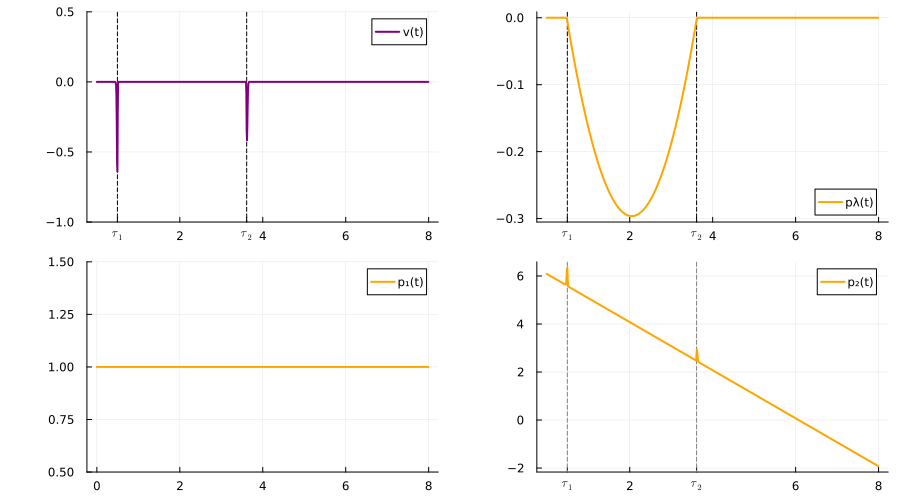

In [7]:
# other plots specific to the direct method

v_plot   = plot(t,  v, label = "v(t)", linecolor=:purple, linewidth=2, ylims=(-1, 0.5))
xticks!(v_plot, [t1,2.,t2,4.,6.,8.], [L"$\tau_1$", "2",L"$\tau_2$","4","6","8"])
vline!(v_plot, [t1], linestyle=:dash, linecolor=:black, label=nothing, z_order=:back)
vline!(v_plot, [t2], linestyle=:dash, linecolor=:black, label=nothing, z_order=:back)

p3_plot   = plot(t,  p3, label = "pλ(t)", linecolor=:orange, linewidth=2)
xticks!(p3_plot, [t1,2.,t2,4.,6.,8.], [L"$\tau_1$", "2",L"$\tau_2$","4","6","8"])
vline!(p3_plot, [t1], linestyle=:dash, linecolor=:black, label=nothing, z_order=:back)
vline!(p3_plot, [t2], linestyle=:dash, linecolor=:black, label=nothing, z_order=:back)

plot(v_plot,p3_plot ,p1_plot,p2_plot, layout = (2,2), size=(900, 500), left_margin=10mm)

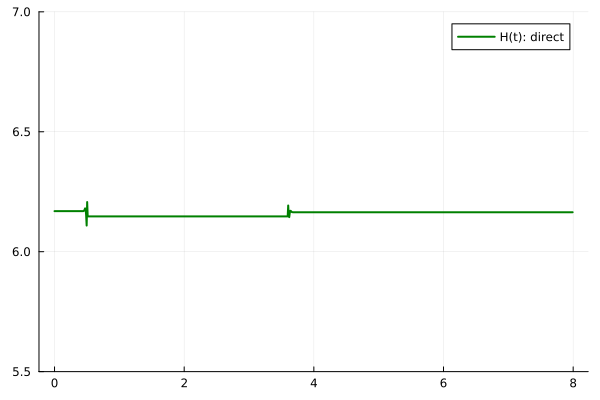

In [8]:
function H(k)
    return p1[k] * x2[k] + p1[k] * (fNC(x2[k])*cos(λ[k]) + fC(x2[k])*cos(u[k])) +
                           p2[k] * (fNC(x2[k])*sin(λ[k]) + fC(x2[k])*sin(u[k])) +
                           p3[k] * fC(x2[k]) * v[k] -
                           ε * v[k]^2 - fNC(x2[k]) * u[k]^2
end

H_direct  = [H(k) for k in 1:length(x1)]
ph_plot   = plot(t, H_direct, label = "H(t): direct", linecolor=:green , linewidth=2, ylims=(5.5, 7))

In [9]:
jmp1 = p2[index1+2]  - p2[index1]
jmp2 = p2[index2+2]  - p2[index2]

println(" p2(t1+) - p2(t1-) = ", jmp1)
println(" p2(t2+) - p2(t2-) = ", jmp2)

 p2(t1+) - p2(t1-) = -0.337988685006648
 p2(t2+) - p2(t2-) = 0.3238832176238047


## Indirect method

In [10]:
using NLsolve
using Animations
using Reel
using Plots
using Plots.PlotMeasures
using LinearAlgebra
include("flow.jl");

In [11]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u), sin(u) ]
end

function G(λ)
    return [ sin(λ), - cos(λ) ]
end

# Hamiltonian: permanent region
H1(x, u, p)  = p' * F(x, u)                 # pseudo-Hamiltonian
u11(x, p)    = atan(p[2]/p[1])              # maximizing control
Hc(x, p)     = H1(x, u11(x, p) , p )        # Hamiltonian

# Flow
fc  = Flow(Hc)

# Hamiltonian: control loss region
H2(x, λ, y, p)   = p' * F(x, λ)   + y* p' *G(λ) # pseudo-Hamiltonian
Hcl(X, P)     = H2(X[1:2], X[3], X[4], P[1:2])  # Hamiltonian

# Flow
fcl  = Flow(Hcl);

In [12]:
# parameters
t0  = 0
tf  = 8
x2f = 4
x0  = [0, 0]

# Shooting function
function shoot(p0, tt1, tt2, λ, jump1, jump2) 
    
    pλ0    = 0
    py0    = 0
    
    x1, p1 = fc(t0, x0, p0, tt1)
    X2, P2 = fcl(tt1, [x1; λ; 0], [p1 - [0, jump1]; pλ0; py0], tt2) # augmented flow
    xf, pf = fc(tt2, X2[1:2], P2[1:2] - [0, jump2], tf)

    s = zeros(eltype(p0), 7)
    s[1]  = xf[2] - x2f # target
    s[2]  = pf[1] - 1.0 # transversality condition
    s[3]  = x1[2] - 0.5 # first crossing 
    s[4]  = X2[2] - 3.5 # second crossing 
    s[5]  = P2[4]       # averaged gradient condition
    s[6]  = jump1 - (p1[1]*(cos(λ) - cos(u11(x1, p1)))           + 
                     p1[2]*(sin(λ) - sin(u11(x1, p1))))/(sin(λ))                                              # jump 1
    s[7]  = jump2 - (P2[1]*(cos(u11(X2[1:2], P2[1:2])) - cos(λ)) + 
                     P2[2]*(sin(u11(X2[1:2], P2[1:2])) - sin(λ)))/(sin(u11(X2[1:2], P2[1:2])))                # jump 2

    return s

end;

In [13]:
# Solve

S(ξ)    = shoot(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], ξ[7])
ξ_guess = [p1[1], p2[1], t1[1], t2[1], λ[(index1+index2)÷2], jmp1, jmp2] # initial guess
println("Initial value of shooting:\n", S(ξ_guess), "\n\n")

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0   = indirect_sol.zero[1:2]
    tt1   = indirect_sol.zero[3]
    tt2   = indirect_sol.zero[4]
    a     = indirect_sol.zero[5]
    jmp11 = indirect_sol.zero[6]
    jmp22 = indirect_sol.zero[7]

else
    error("Not converged")
end;

Initial value of shooting:
[0.05007226071378135, 0.0, -0.011617047560808114, 0.013492751980266338, 0.2568239312461033, -0.3251275640733963, 0.3085873259832842]


Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.251276e-01              NaN
     1     2.901690e-03     4.423209e-01
     2     2.455838e-06     3.474638e-03
     3     3.406229e-13     5.064949e-07
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 6.087321019322859, 0.4955044955044955, 3.612387612387612, 1.3275286734022251, -0.337988685006648, 0.3238832176238047]
 * Zero: [1.0, 6.088879620621635, 0.5073023447991126, 3.5974522435428518, 1.3286547556171466, -0.01228198993970171, 0.027541288724319064]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4


In [14]:
# jumps from direct solution
println(" jumps from direct solution")
println(" p2(t1+) - p2(t1-) = ", jmp1)
println(" p2(t2+) - p2(t2-) = ", jmp2)
println("")

# jumps from indirect solution
println(" jumps from indirect solution")
println(" p2(t1+) - p2(t1-) = ", jmp11)
println(" p2(t2+) - p2(t2-) = ", jmp22)

 jumps from direct solution
 p2(t1+) - p2(t1-) = -0.337988685006648
 p2(t2+) - p2(t2-) = 0.3238832176238047

 jumps from indirect solution
 p2(t1+) - p2(t1-) = -0.01228198993970171
 p2(t2+) - p2(t2-) = 0.027541288724319064


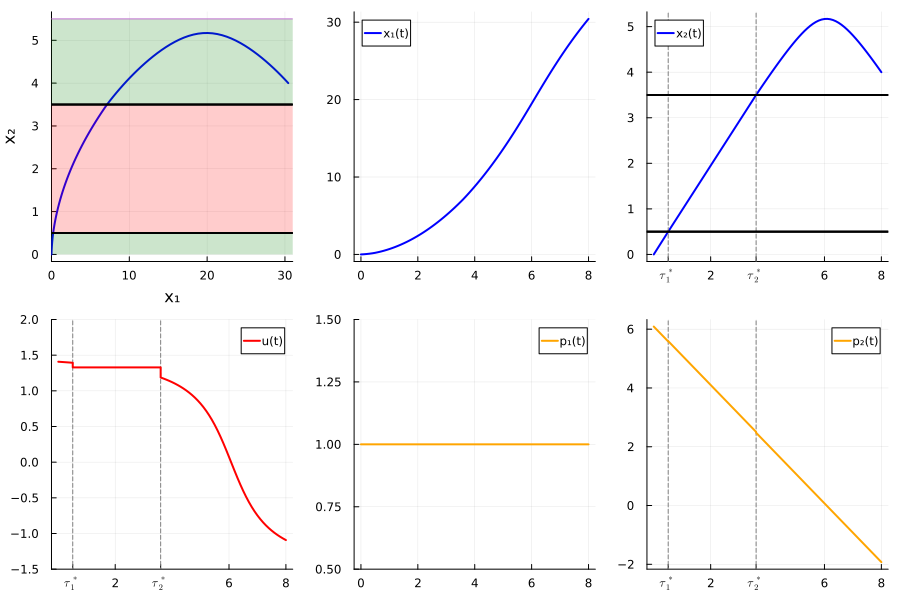

In [15]:
ode_sol = fc((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1 = ode_sol.t ;
xx1 = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1 = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1 = u11.(xx1, pp1)  ;

pλ0 = 0. 
py0 = 0.

ode_sol = fcl((tt1, tt2), [xx1[end] ; a ; 0.0], [pp1[end] - [0. , jmp11]; pλ0 ; py0], saveat=0.1)
ttt2 = ode_sol.t
xx2 = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ]
pp2 = [ ode_sol[5:6, j] for j in 1:size(ttt2, 1) ]
uu2 = a.*ones(length(ttt2)) ;

ode_sol = fc((tt2, tf), xx2[end], pp2[end] - [0. , jmp22], saveat=0.1)
ttt3 = ode_sol.t
xx3 = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ]
pp3 = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] 
uu3 = u11.(xx3, pp3)  ;

t = [ ttt1 ; ttt2 ; ttt3 ]
x = [ xx1 ; xx2 ; xx3 ]
p = [ pp1 ; pp2 ; pp3 ]
u = [ uu1 ; uu2 ; uu3 ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t, x1, label="x₁(t)", linecolor=:blue, linewidth=2)

x2_plot   = plot(t,  x2, label="x₂(t)", linecolor=:blue, linewidth=2)
xticks!(x2_plot, [ttt1[end],2.,ttt2[end],6.,8.], [L"$\tau_1^*$", "2",L"$\tau_2^*$","6","8"])
vline!(x2_plot, [ttt1[end]], linestyle=:dash, linecolor=:gray, label=nothing)
vline!(x2_plot, [ttt2[end]], linestyle=:dash, linecolor=:gray, label=nothing)
hline!([(0., 0.5), (8., 0.5)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 3.5), (8., 3.5)], linecolor=:black, linewidth=2, label=false)

p1_plot   = plot(t, p1, label="p₁(t)", linecolor=:orange, linewidth=2, ylims=(0.5, 1.5))

p2_plot   = plot(t,  p2, label="p₂(t)", linecolor=:orange, linewidth=2)
xticks!(p2_plot, [ttt1[end],2.,ttt2[end],6.,8.], [L"$\tau_1^*$", "2",L"$\tau_2^*$","6","8"])
vline!(p2_plot, [ttt1[end]], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(p2_plot, [ttt2[end]], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)

u_plot    = plot(t,   u, label="u(t)" ,linecolor=:red ,linewidth=2, ylims=(-1.5, 2))
xticks!(u_plot, [ttt1[end],2.,ttt2[end],6.,8.], [L"$\tau_1^*$", "2",L"$\tau_2^*$","6","8"])
vline!(u_plot, [ttt1[end]], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)
vline!(u_plot, [ttt2[end]], linestyle=:dash, linecolor=:gray, label=nothing, z_order=:back)

x1x2_plot = plot(x1, x2, xlabel = "x₁", ylabel = "x₂",   legend=false, linecolor=:blue, linewidth=2)
plot!(x1x2_plot, [0., 31.], [0.5, 0.5], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green, label=false)
plot!(x1x2_plot, [0., 31.], [3.5, 3.5], fillrange = 0.5, fillalpha = 0.2, fillcolor = :red, label=false)
plot!(x1x2_plot, [0., 31.], [5.5, 5.5], fillrange = 3.5, fillalpha = 0.2, fillcolor = :green, label=false)
hline!([(0., 0.5), (31., 0.5)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 3.5), (31., 3.5)], linecolor=:black, linewidth=2, label=false)
xlims!(0, 31)

x = plot(x1x2_plot,x1_plot, x2_plot,u_plot,p1_plot, p2_plot , layout = (2, 3), size=(900, 600))




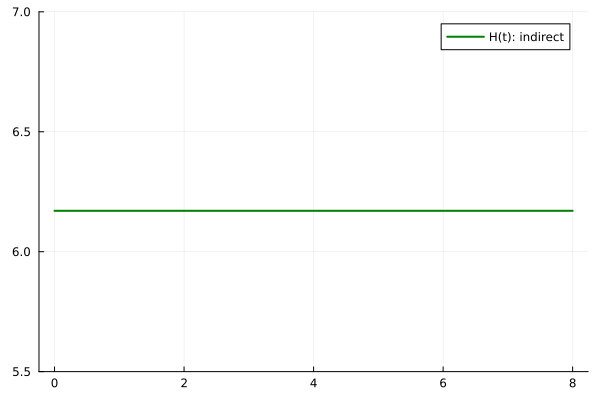

In [16]:
function HH(k)
    return p1[k] * (x2[k] + cos(u[k])) + p2[k] * sin(u[k])
end

H_indirect  = [HH(k) for k in 1:length(x2)]
ph_plot   = plot(t, H_indirect, label = "H(t): indirect", linecolor=:green , linewidth=2, ylims=(5.5, 7))

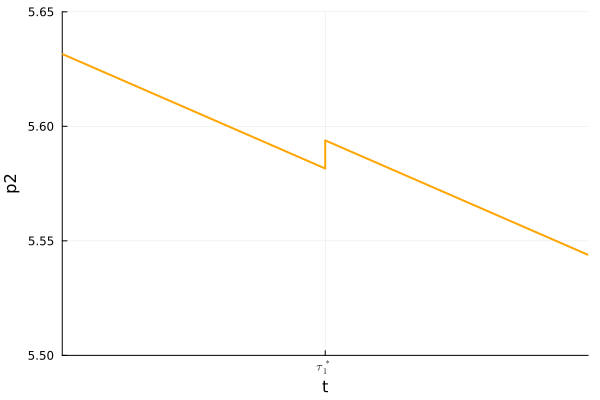

In [151]:
p2_plot = plot(t, p2, xlabel = "t", ylabel = "p2", legend=false, linecolor=:orange, linewidth=2)
xticks!(p2_plot, [ttt1[end], 2., ttt2[end], 6., 8.], [L"$\tau_1^*$", "2", L"$\tau_2^*$", "6", "8"])

xlims!(p2_plot, (ttt1[end]-0.05, ttt1[end]+0.05))
ylims!(p2_plot, (5.50, 5.65))


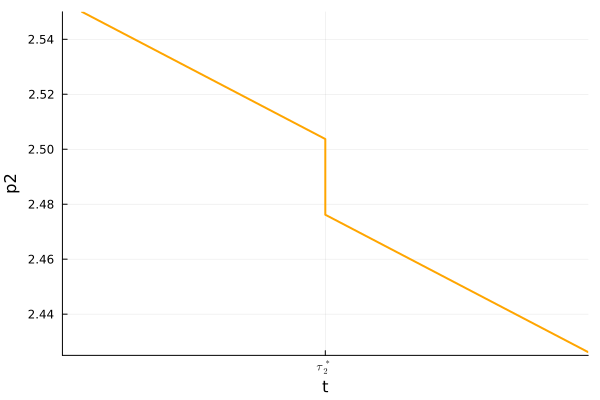

In [152]:

p2_plot = plot(t, p2, xlabel = "t", ylabel = "p2", legend=false, linecolor=:orange, linewidth=2)
xticks!(p2_plot, [ttt1[end], 2., ttt2[end], 6., 8.], [L"$\tau_1^*$", "2", L"$\tau_2^*$", "6", "8"])

xlims!(p2_plot, (ttt2[end]-0.05, ttt2[end]+0.05))
ylims!(p2_plot, (2.4250,2.55))

In [153]:
# create an animation
animx = @animate for i = 1:length(t)
    plot(x1[1:i], x2[1:i], xlim=(0.,31.), ylim=(-0.,5.5), xlabel="x1", ylabel="x2", label="optimal trajectory \$x\$", linecolor=:blue,  linewidth=2)
    scatter!([x1[i]], [x2[i]], markersize=4, marker=:circle, color=:black, label=false)
    plot!( [0., 31.], [0.5, 0.5], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green, label=false)
    plot!( [0., 31.], [3.5, 3.5], fillrange = 0.5, fillalpha = 0.2, fillcolor = :red, label=false)
    plot!( [0., 31.], [5.5, 5.5], fillrange = 3.5, fillalpha = 0.2, fillcolor = :green, label=false)

end

# create an animation
animu = @animate for i = 1:length(t)
    plot(t[1:i], u[1:i], xlim=(0.,8.), ylim=(-pi/2,pi/2), xlabel="t", ylabel="u", label="opitmal control \$u\$", linecolor=:red,  linewidth=2)
end ;

# create an animation
animp1 = @animate for i = 1:length(t)
    plot(t[1:i], p1[1:i], xlim=(0.,8.), ylim=(0.,2.), xlabel="t", ylabel="p1", label="adjoint vector \$p1\$", linecolor=:orange,  linewidth=2)
end ;

# create an animation
animp2 = @animate for i = 1:length(t)
    plot(t[1:i], p2[1:i], xlim=(0.,8.), ylim=(-2.2,6.), xlabel="t", ylabel="p2", label="adjoint vector \$p2\$", linecolor=:orange,  linewidth=2)
end ;

┌ Info: Saved animation to /Users/ocots/Boulot/recherche/control-loss/simulations/control-loss/zermelo/zer1_x.gif
└ @ Plots /Users/ocots/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/Users/ocots/Boulot/recherche/control-loss/simulations/control-loss/zermelo/zer1_x.gif")
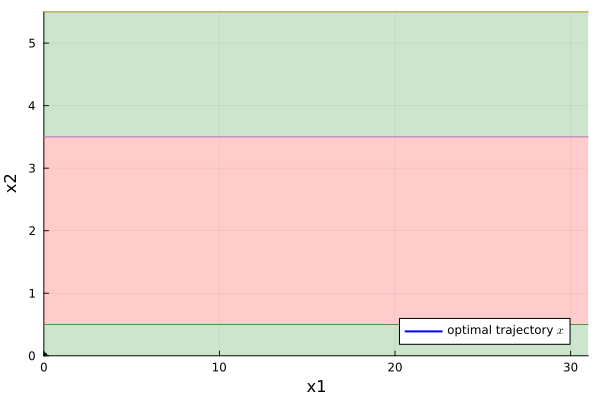

In [154]:
# display the animation
gif(animx, "zer1_x.gif", fps = 10)

┌ Info: Saved animation to /Users/ocots/Boulot/recherche/control-loss/simulations/control-loss/zermelo/zer1_u.gif
└ @ Plots /Users/ocots/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/Users/ocots/Boulot/recherche/control-loss/simulations/control-loss/zermelo/zer1_u.gif")
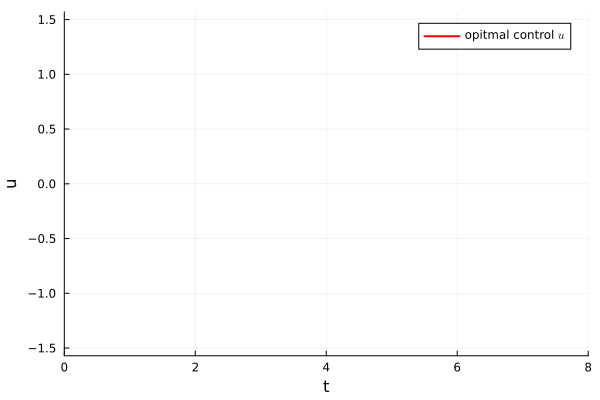

In [155]:
gif(animu, "zer1_u.gif", fps = 10)

┌ Info: Saved animation to /Users/ocots/Boulot/recherche/control-loss/simulations/control-loss/zermelo/zer1_p1.gif
└ @ Plots /Users/ocots/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/Users/ocots/Boulot/recherche/control-loss/simulations/control-loss/zermelo/zer1_p1.gif")
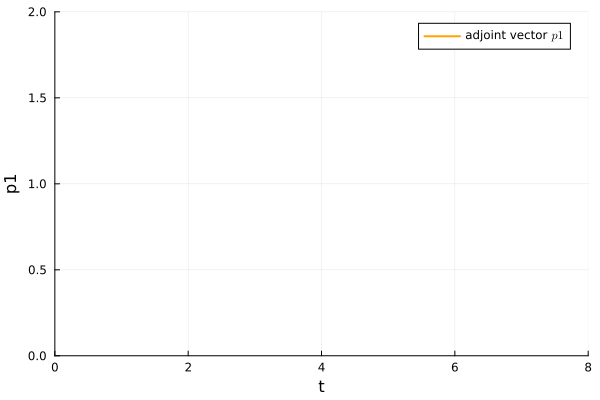

In [156]:
# display the animation
gif(animp1, "zer1_p1.gif", fps = 10)

┌ Info: Saved animation to /Users/ocots/Boulot/recherche/control-loss/simulations/control-loss/zermelo/zer_p2.gif
└ @ Plots /Users/ocots/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/Users/ocots/Boulot/recherche/control-loss/simulations/control-loss/zermelo/zer_p2.gif")
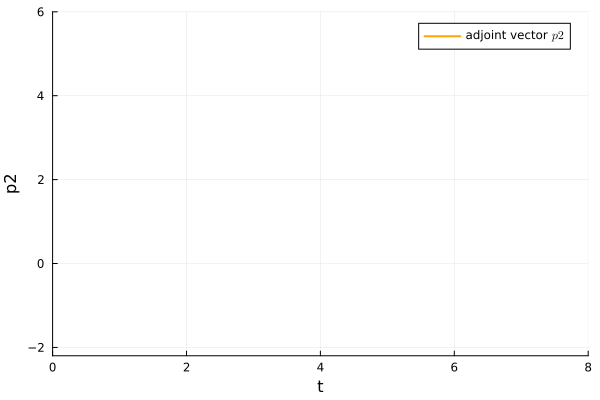

In [157]:
# display the animation
gif(animp2, "zer_p2.gif", fps = 10)